In [68]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.datasets import cifar10
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

In [2]:
# Load CIFAR-10 dataset
(x_train, _), (_, _) = cifar10.load_data()
xtrain_org = x_train.copy()
# Preprocess images
x_train = tf.image.resize(x_train, (32, 32))  # Resize to fit VGG16 input size requirement
x_train = preprocess_input(x_train)  # Preprocess the input data in the way VGG16 expects

In [3]:
x_train.shape

TensorShape([50000, 32, 32, 3])

In [4]:
train_dataset = x_train

### Extracting features from all training images in the CIFAR 10 dataset.

In [5]:
# Load VGG16 model with weights pre-trained on ImageNet
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

80134624/80134624 [==============================] - 1s 0us/step


In [6]:
# Extract features from CIFAR-10
features = model.predict(train_dataset)
features = features.reshape(features.shape[0], -1)  # Flatten the features to make them easier to compare

1563/1563 [==============================] - 668s 427ms/step


In [7]:
features = np.array( [features[i].flatten() for i in range(train_dataset.shape[0])] )
file_name = 'CIFAR_Full_features_32.npy'
np.save(file_name, features)

In [8]:
file_name = 'CIFAR_Full_features_32.npy'
features = np.load(file_name)

In [65]:
def get_top_similar(query_img_path, features, top_n=5, rows_shift=0, rot_angle=0):
    # Load and preprocess the query image

    if type(query_img_path)==str:
        query_img = load_img(query_img_path, target_size=(32, 32))
        query_img = img_to_array(query_img)

    else:
        query_img = query_img_path

    # # Rotate the image by the specified angle
    # query_img = tf.image.rot90(query_img, k=rot_angle // 90)

    height, width = query_img.shape[0], query_img.shape[1]
    center = (width / 2, height / 2)
    rot_matrix = cv2.getRotationMatrix2D(center, rot_angle, 1.0)
    query_img = cv2.warpAffine(query_img, rot_matrix, (width, height))

    query_img = query_img[rows_shift:, :, :]
    if query_img.shape[2] == 4:  # Check if the image has an alpha channel
        new_rows = np.zeros((rows_shift, query_img.shape[1], 4))  # Replace '0' with other values if needed
    else:
        new_rows = np.zeros((rows_shift, query_img.shape[1], 3))  # RGB without alpha

    # Add 4 new pixel rows at the bottom
    query_img = np.vstack((query_img, new_rows))

    query_img = preprocess_input(query_img)
    query_img = np.expand_dims(query_img, axis=0)

    # Extract features from the query image
    query_features = model.predict(query_img)
    query_features = query_features.flatten().reshape(1, -1)

    # Calculate similarity between query features and CIFAR-10 features
    similarity = cosine_similarity(query_features, features)

    # Get the top N most similar images
    top_indices = np.argsort(similarity[0])[::-1][:top_n]
    return top_indices

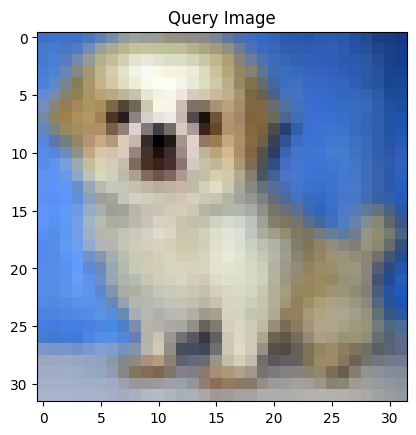

In [92]:
# Example usage
import matplotlib.image as mpimg

query_img_path = '/content/dog1.png'
query_img = mpimg.imread(query_img_path)
plt.imshow(query_img)
plt.title("Query Image")
plt.show()

1/1 [==============================] - 0s 72ms/step
[11519 18568 16134 18721 43672]


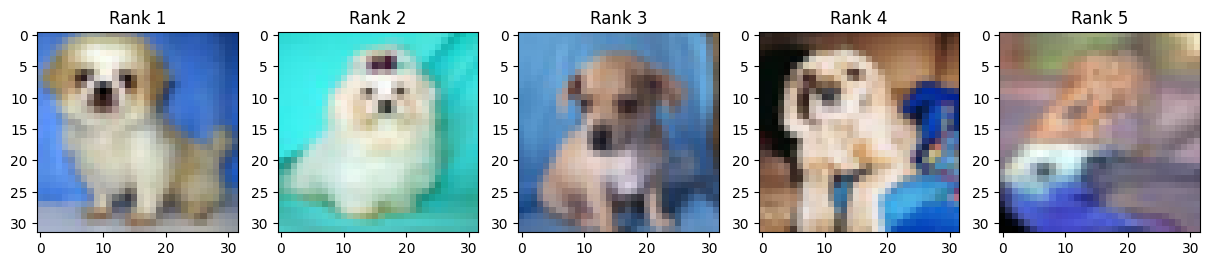

In [93]:
top_indices = get_top_similar(query_img_path, features, rows_shift=0, rot_angle=0)
print(top_indices)
plt.figure(figsize=(15, 6))
for i in range(len(top_indices)):
    plt.subplot(1, len(top_indices), i + 1)
    plt.imshow(xtrain_org[top_indices[i]]/255)
    plt.title(f"Rank {i+1}")
plt.show()

In [97]:
### For loop for accuracy
acc, acc5, total_images = 0, 0, 1000
for i in range(total_images):
    random_idx = np.random.randint(0,50000)
    query_img = xtrain_org[random_idx]
    top_indices = get_top_similar(query_img, features, top_n=5, rows_shift=2)
    # print(random_idx, top_indices[0])
    if top_indices[0]==random_idx:
        acc+=1
    if random_idx in top_indices:
        acc5+=1

print('Accuracy:', acc/total_images)
print('Accuracy 5:', acc5/total_images)

1/1 [==============================] - 0s 61ms/step
Accuracy: 0.421
Accuracy 5: 0.574
